In [1]:
import os
import json
import time
import tempfile
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from IPython.display import Image, display


In [8]:
class NaverShoppingCrawler:
    def __init__(self):
        self.driver = self._create_driver()
        self.products = []

    def _create_driver(self):
        options = Options()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument(
            "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument(f'--user-data-dir={tempfile.mkdtemp()}')
        driver = webdriver.Chrome(options=options)
        return driver

    def show_screenshot(self, filename='screenshot.png'):
        # 파일로 저장
        self.driver.save_screenshot(filename)
        
        # 노트북에서 바로 표시
        display(Image(filename=filename, width=500))

    
    def open_page(self, url):
        self.driver.maximize_window()
        
        self.driver.get(url)
    
    def search(self, keyword):
        try:
            driver = self.driver
            self.show_screenshot()
            driver.implicitly_wait(3)
            search_word = '캠핑 숯'
            search_box = driver.find_element(By.XPATH, '//input[contains(@class, "searchInput_search_text")]')
            
            search_box.clear()
            search_box.send_keys(search_word)
            self.show_screenshot()
            time.sleep(1)
            search_box.send_keys(Keys.ENTER)
            time.sleep(2)
            self.show_screenshot()
            print("현재 페이지 제목:", driver.title)
            
            
        except TimeoutException:
            self.close()
            print("검색창 또는 결과 로딩에 실패했습니다.")

    def scroll_page(self, scroll_count=1):
        last_height = self.driver.execute_script("return document.body.scrollHeight")
        try:
            for _ in range(scroll_count):
                self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                new_height = self.driver.execute_script("return document.body.scrollHeight")
                self.show_screenshot()
                if new_height == last_height:
                    break
                last_height = new_height
        except:
            self.close()
    def print_parce_product(self):
        items_path = '//*[@id="composite-card-list"]/div/ul[1]/li'
        
        items = self.driver.find_elements(By.XPATH, items_path)
        print(f"상품 개수: {len(items)}")
        for i, item in enumerate(items, start=1):
            print(f"{i}번째 상품: ", end="")
            try:
                a_tag = item.find_element(By.XPATH, './/div/a[contains(@class, "basicProductCard")]')
                info = a_tag.get_attribute('data-shp-contents-dtl')
                info_dict = json.loads(info)

                name = next(d['value'] for d in info_dict if d['key'] == 'prod_nm')
                price = next(d['value'] for d in info_dict if d['key'] == 'price')
                # link = a_tag.get_attribute('href')
                # image_url = item.find_element(By.XPATH, './/img').get_attribute('src')
                print(f'{price} -{name}')
                self.products.append({
                    '상품명': name,
                    '가격': price,
                    # '링크': link,
                    # '이미지': image_url
                })
            except Exception as e:
                print(f"오류 발생: {e}")

        
            
        
    def parse_products(self):
        items_path = '//*[@id="composite-card-list"]/div/ul[1]/li'
        
        items = self.driver.find_elements(By.XPATH, items_path)
        print(f"상품 개수: {len(items)}")
        for i, item in enumerate(items, start=1):
            print(f"{i}번째 상품: ", end="")
            try:
                a_tag = item.find_element(By.XPATH, './/div/a[contains(@class, "basicProductCard")]')
                info = a_tag.get_attribute('data-shp-contents-dtl')
                info_dict = json.loads(info)

                name = next(d['value'] for d in info_dict if d['key'] == 'prod_nm')
                price = next(d['value'] for d in info_dict if d['key'] == 'price')
                link = a_tag.get_attribute('href')
                image_url = item.find_element(By.XPATH, './/img').get_attribute('src')

                self.products.append({
                    '상품명': name,
                    '가격': price,
                    '링크': link,
                    '이미지': image_url
                })
                print(name)
            except Exception as e:
                print(f"오류 발생: {e}")
        
    def download_images(self, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        for i, product in enumerate(self.products):
            try:
                img_url = product['이미지']
                img_ext = os.path.splitext(img_url)[1].split('?')[0]
                img_path = os.path.join(folder_path, f"product_{i+1}{img_ext or '.jpg'}")

                response = requests.get(img_url, timeout=5)
                with open(img_path, 'wb') as f:
                    f.write(response.content)

                product['이미지_파일'] = img_path
            except Exception as e:
                print(f"이미지 다운로드 실패 (#{i+1}): {e}")
                product['이미지_파일'] = '다운로드 실패'

    def save_to_excel(self, file_path):
        dir_path = os.path.dirname(file_path)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        df = pd.DataFrame(self.products)
        self.crwal_df = df.copy()
        df.to_excel(file_path, index=False)
        print(f"엑셀 파일이 {file_path}에 저장되었습니다.")

    def close(self):
        self.driver.quit()

    def search_run(self, keyward = "라면"):
        self.open_page('https://shopping.naver.com/home')
        self.search(keyward)
        
        self.scroll_page()
        self.parse_products()
        self.download_images('./data/images')
        self.save_to_excel('./data/naver_shopping_camping_charcoal.xlsx')
        self.close()
        # ✅ 현재 페이지 제목 출력

        

In [9]:
crawler = NaverShoppingCrawler()



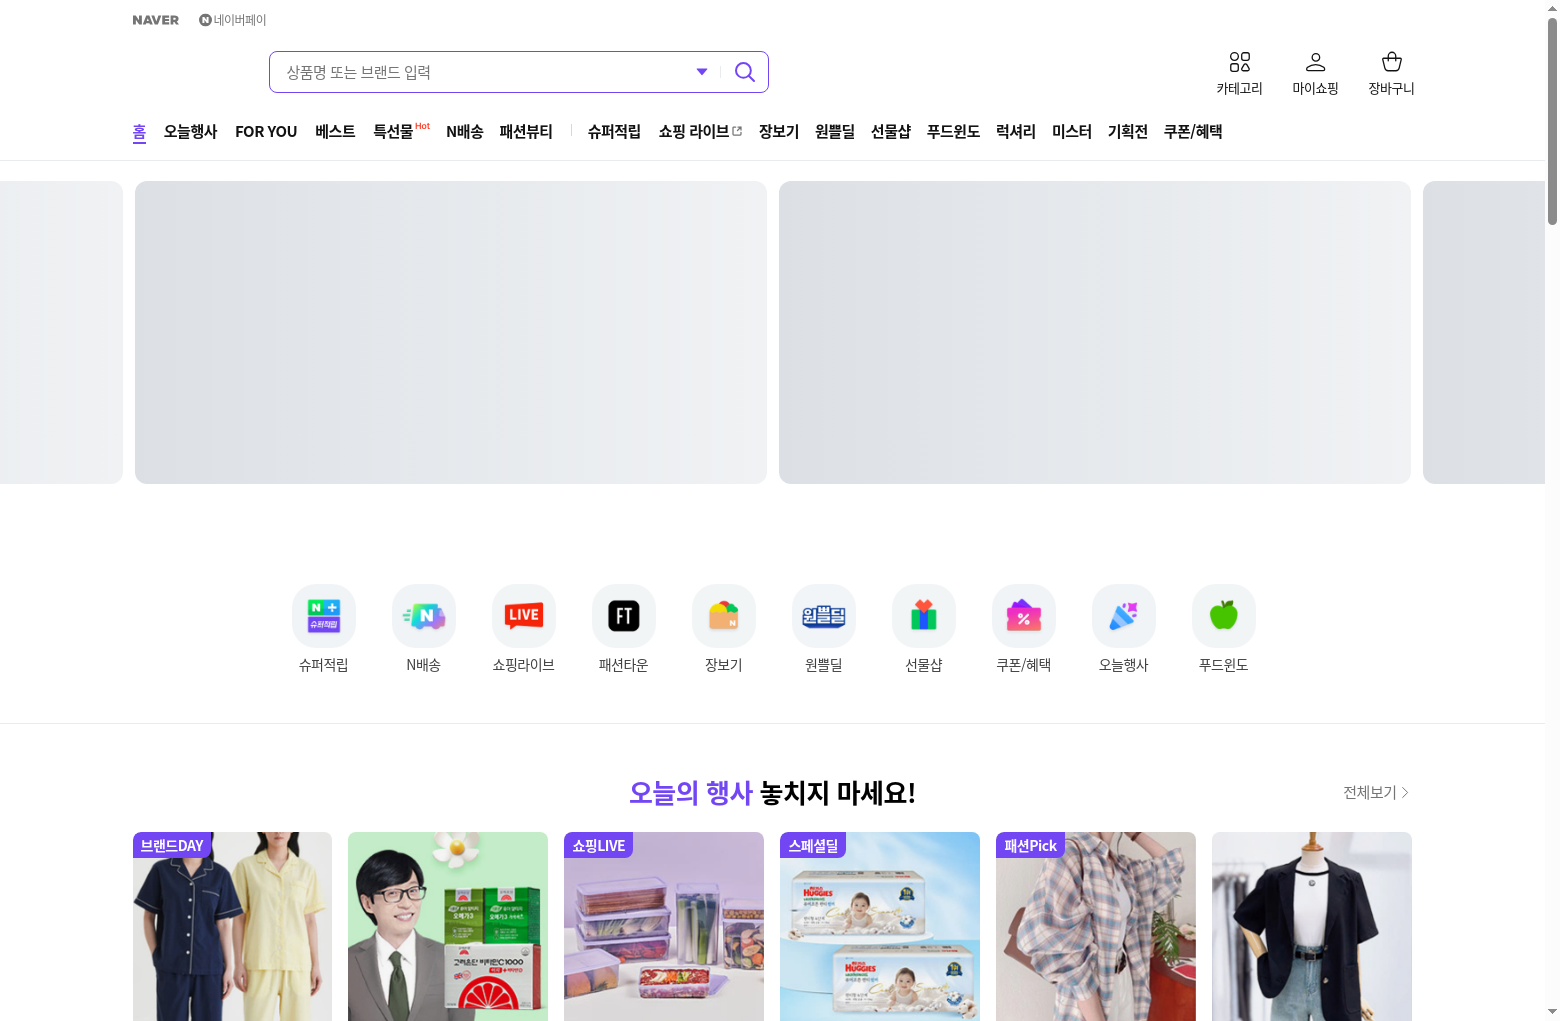

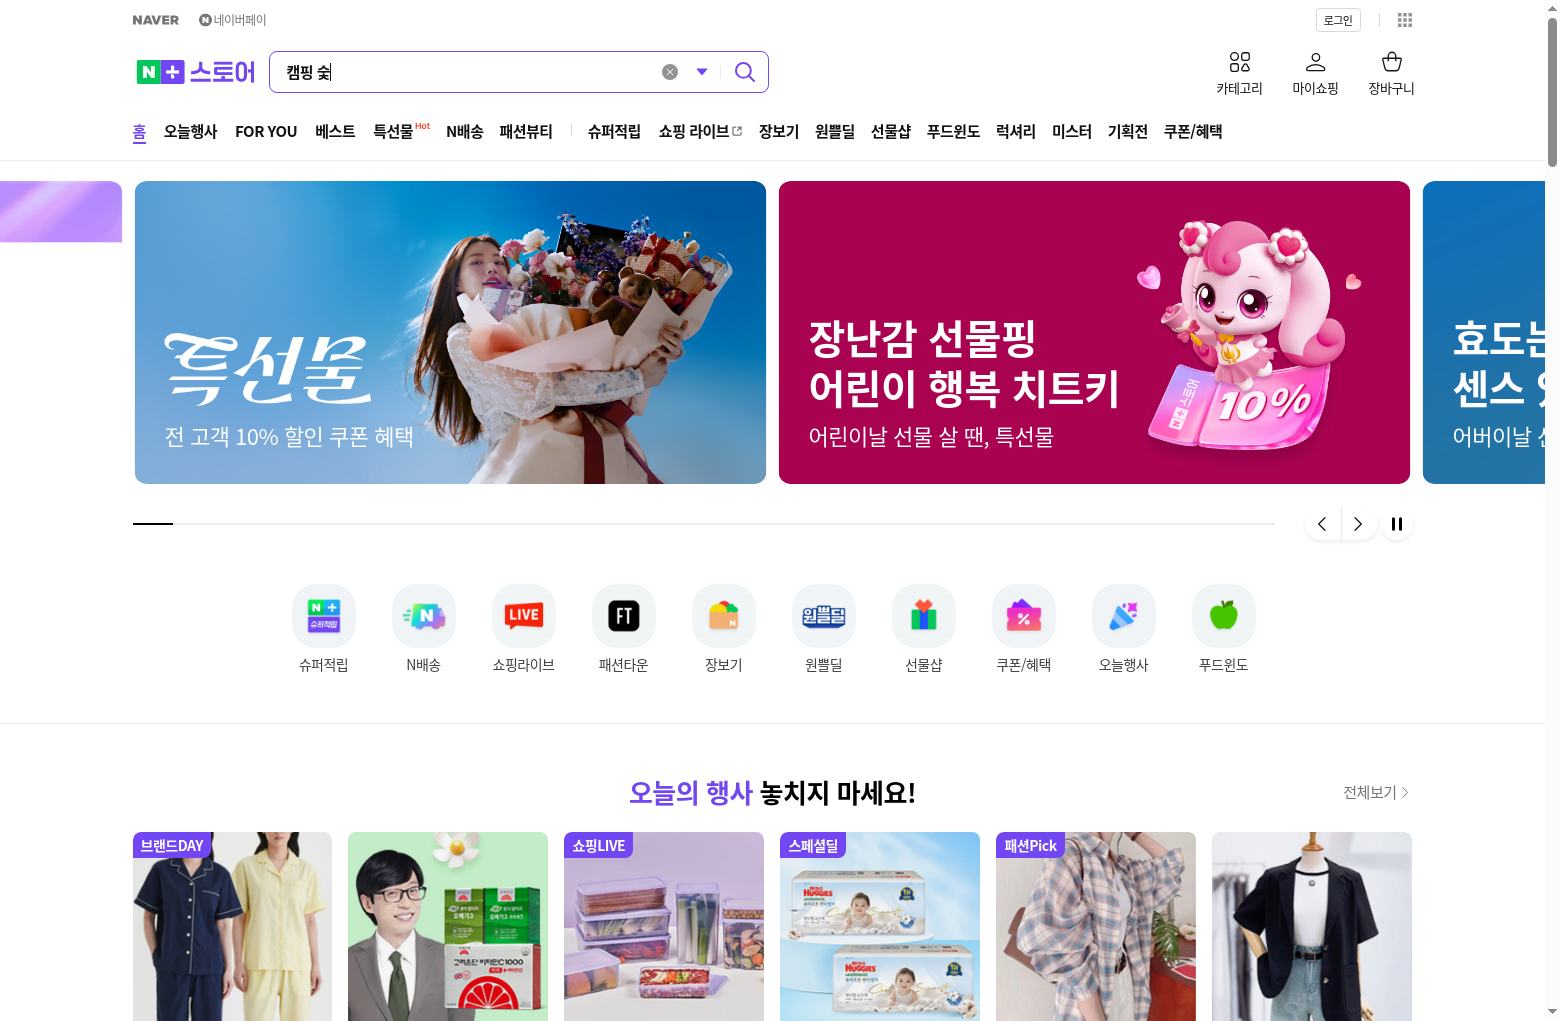

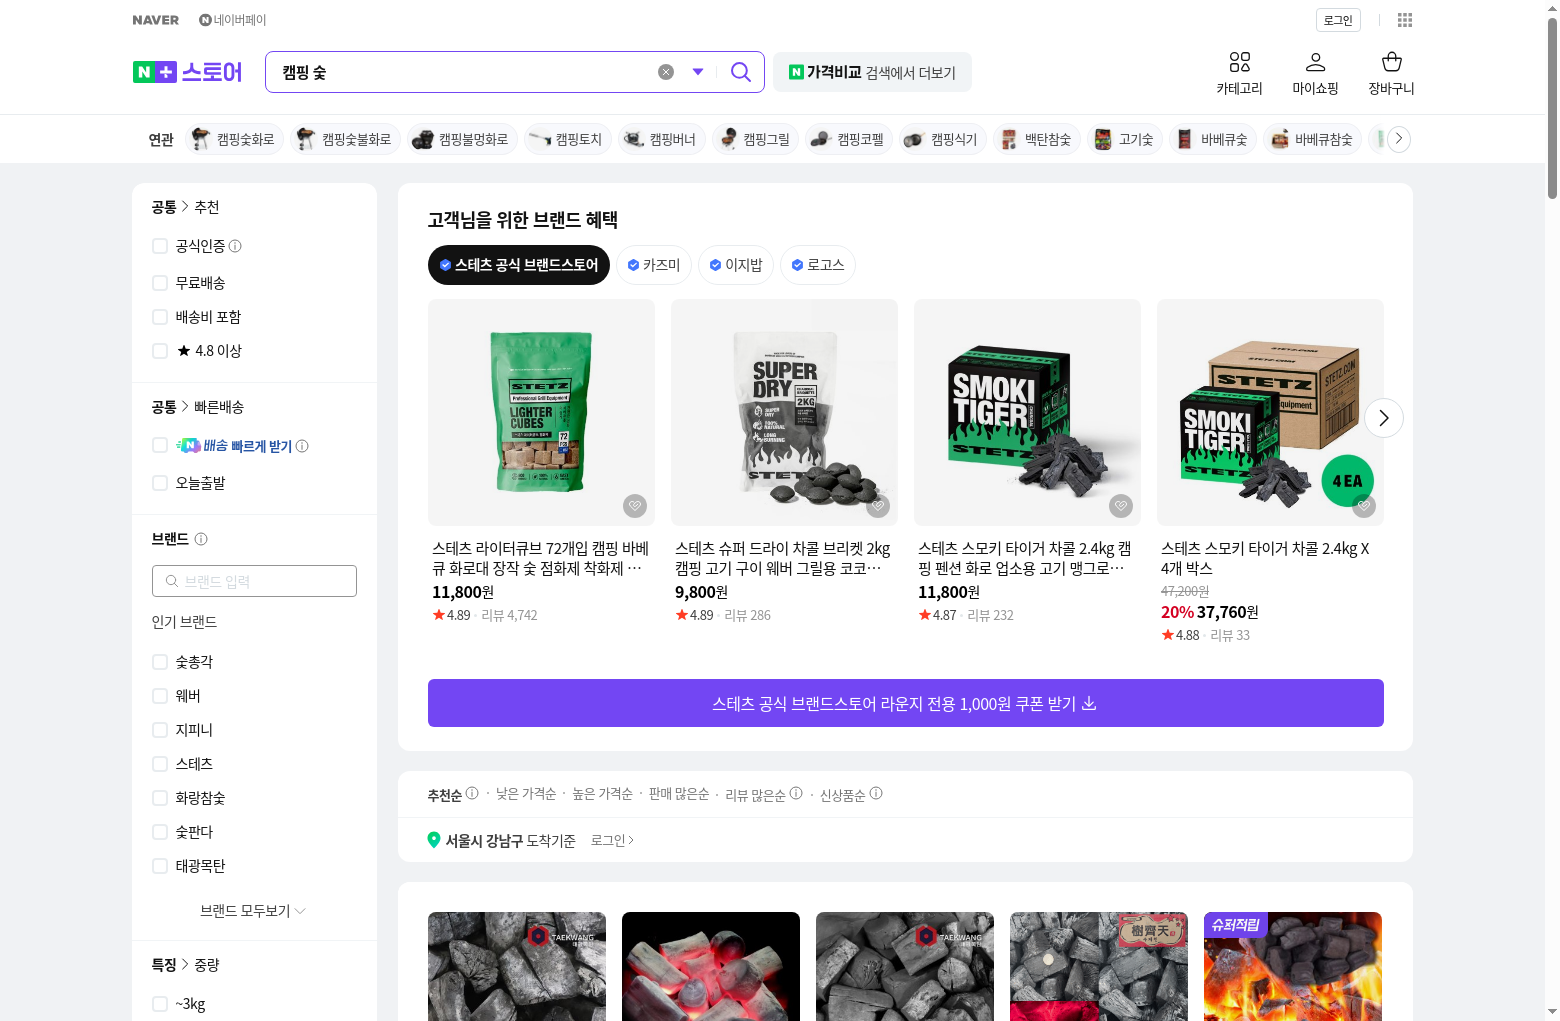

현재 페이지 제목: 캠핑 숯 : 네이버+ 스토어 검색


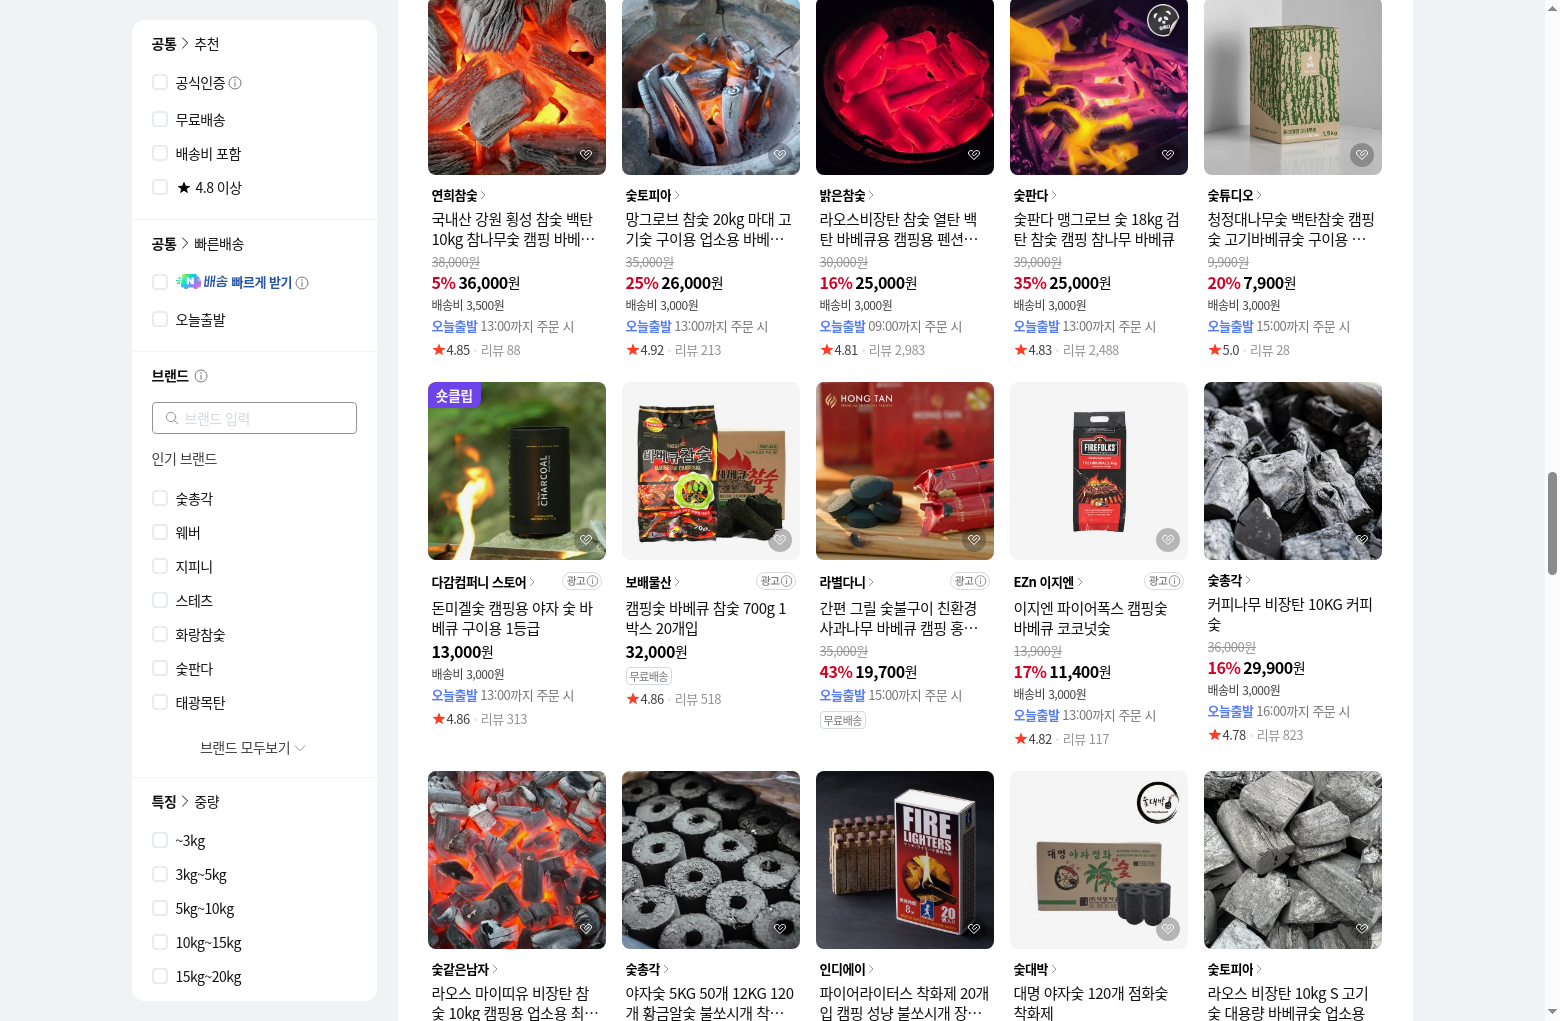

상품 개수: 104
1번째 상품: 27000 -태광목탄 커피나무숯 백탄 펜션 바베큐 고기 구이 업소용 캠핑용 목탄 커피 9kg ss
2번째 상품: 25000 -라오스 유칼립투스 비장탄 백탄 캠핑숯 10kg
3번째 상품: 26000 -마이띠유 비장탄 라오스비장탄2주 M 숯 고기집 구이용 업소용 도매 백탄 10kg
4번째 상품: 29000 -수제천 비장탄 커피나무 커피숯 참숯 캠핑용 업소용 10kg
5번째 상품: 7900 -차크닉 바베큐 참숯 3kg 유칼립투스 프리미엄 캠핑 비장탄 펜션 구이용 직화 숯
6번째 상품: 14900 -참숯 바베큐 캠핑 고기 펜션 숯 구이용 예랑참숯 백탄 비장탄 2.5kg
7번째 상품: 16000 -업소용 캠핑 튀지않는 구이용 고기숯 참나무 바베큐 펜션 차콜 한마음참숯 백탄 비장탄3kg
8번째 상품: 25000 -최고급 국내산 3단 구이용바베큐 백탄참나무 캠핑용 고기숯 펜션 한마음참숯 비장탄 10kg
9번째 상품: 20000 -조개탄 야자 숯 10kg 캠핑숯 바베큐숯 차콜브리켓
10번째 상품: 28800 -최고급 3단 참숯 검탄 20kg 참나무숯 고기숯 바베큐숯
11번째 상품: 9900 -국내산 두번구운 참숯 비장탄 숯 백탄 고기 바베큐 캠핑용 업소용 야자 장작 차콜2.5kg
12번째 상품: 19900 -국내산 강원 횡성 참숯 백탄 5kg 참나무숯 캠핑 바베큐 고기 구이용 숯
13번째 상품: 9900 -꾸버스 캔디 착화제 숯 장작 캠핑 불쏘시개 개별포장 25개입
14번째 상품: 9900 -마이띠유비장탄 백탄참숯 캠핑숯 차콜 고기바베큐숯 숫 3kg
15번째 상품: 26890 -프리미엄 참숯 백탄 캠핑용 업소용 구이용숯 바베큐숯 5kg (엔에스)
16번째 상품: 오류 발생: Message: no such element: Unable to locate element: {"method":"xpath","selector":".//div/a[contains(@class, "basicProductCard")]"}
  (Session info: chr

In [10]:
crawler = NaverShoppingCrawler()
crawler.open_page('https://shopping.naver.com/home')
crawler.search('비장탄')

crawler.scroll_page()
crawler.print_parce_product()

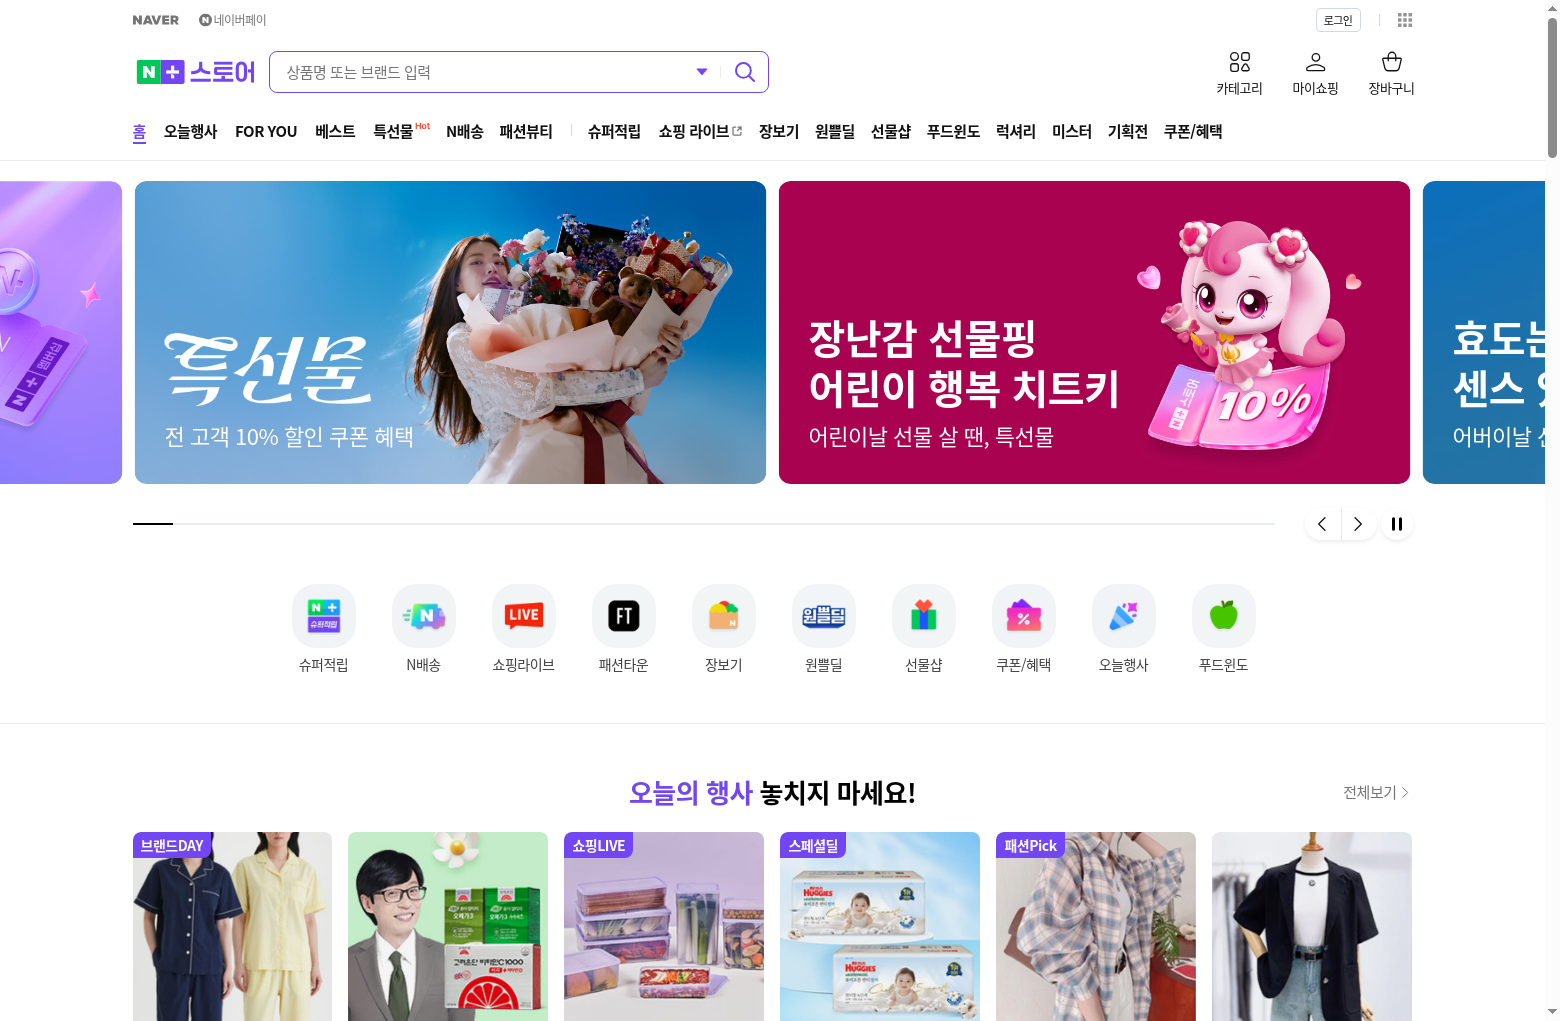

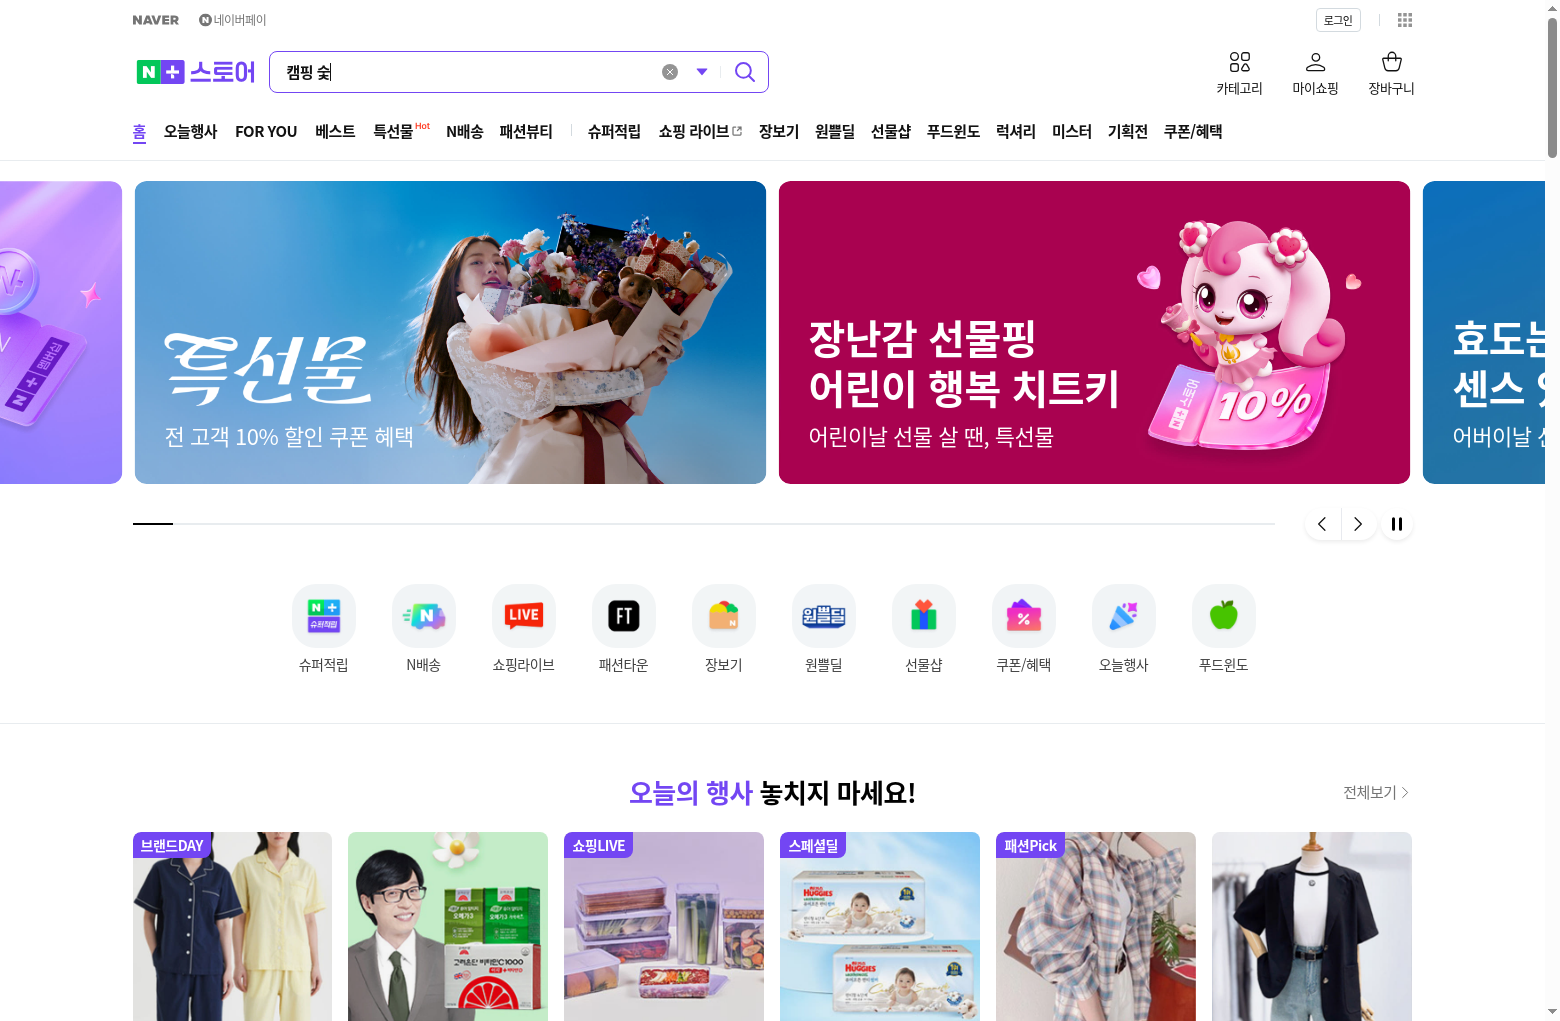

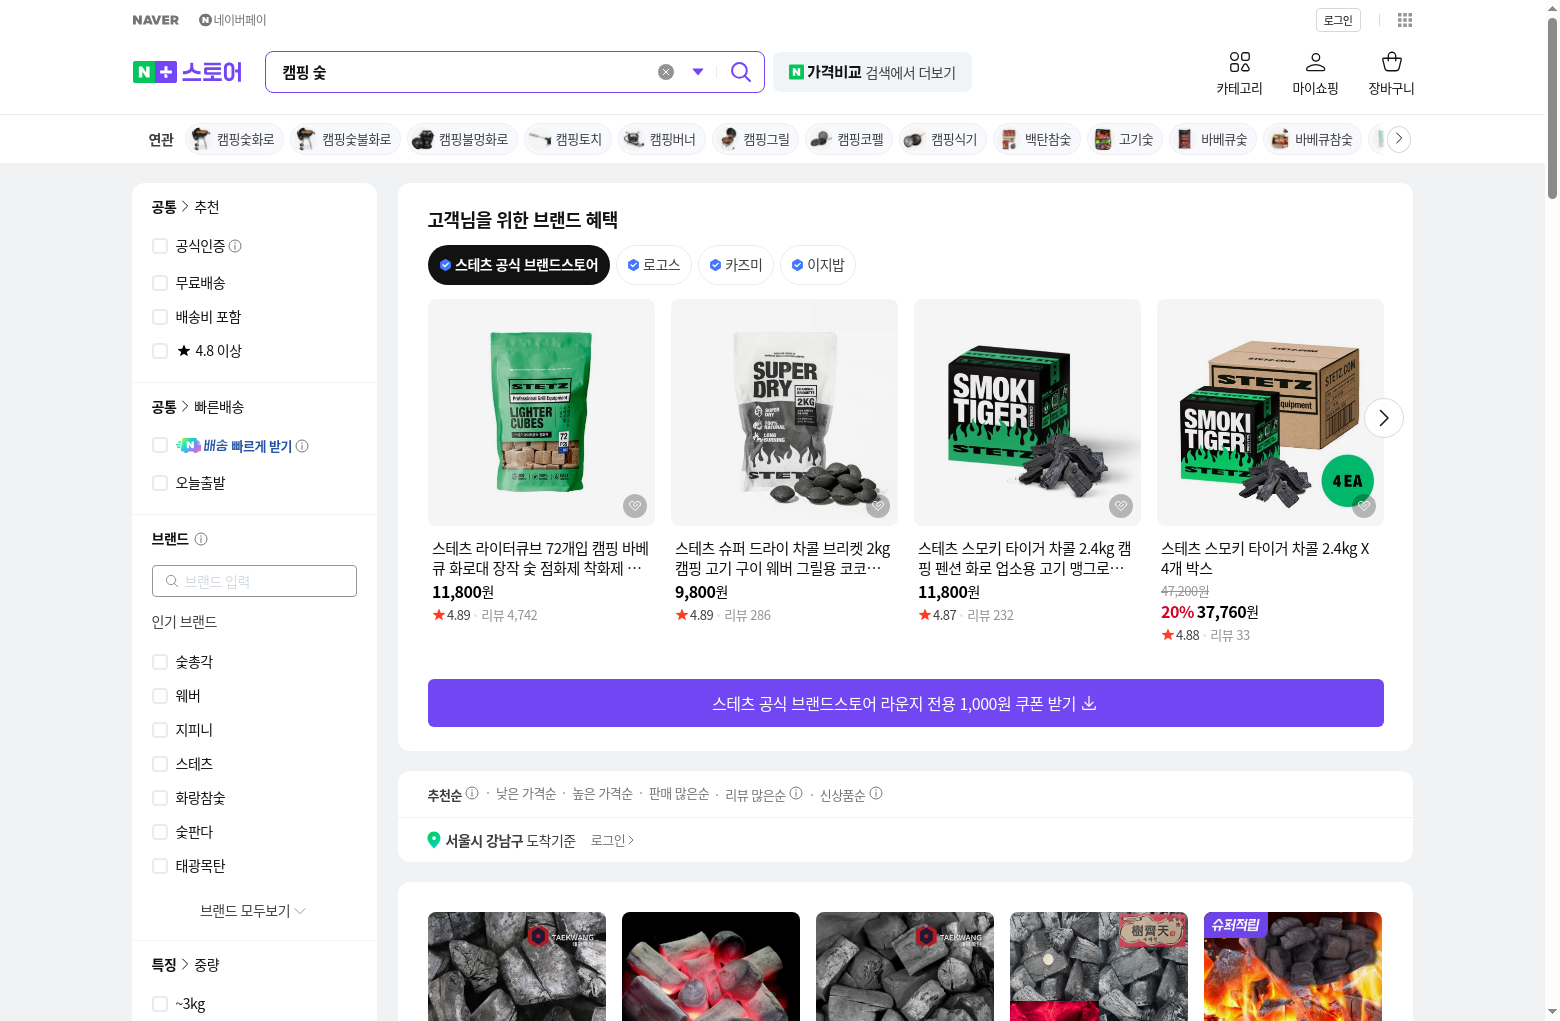

현재 페이지 제목: 캠핑 숯 : 네이버+ 스토어 검색


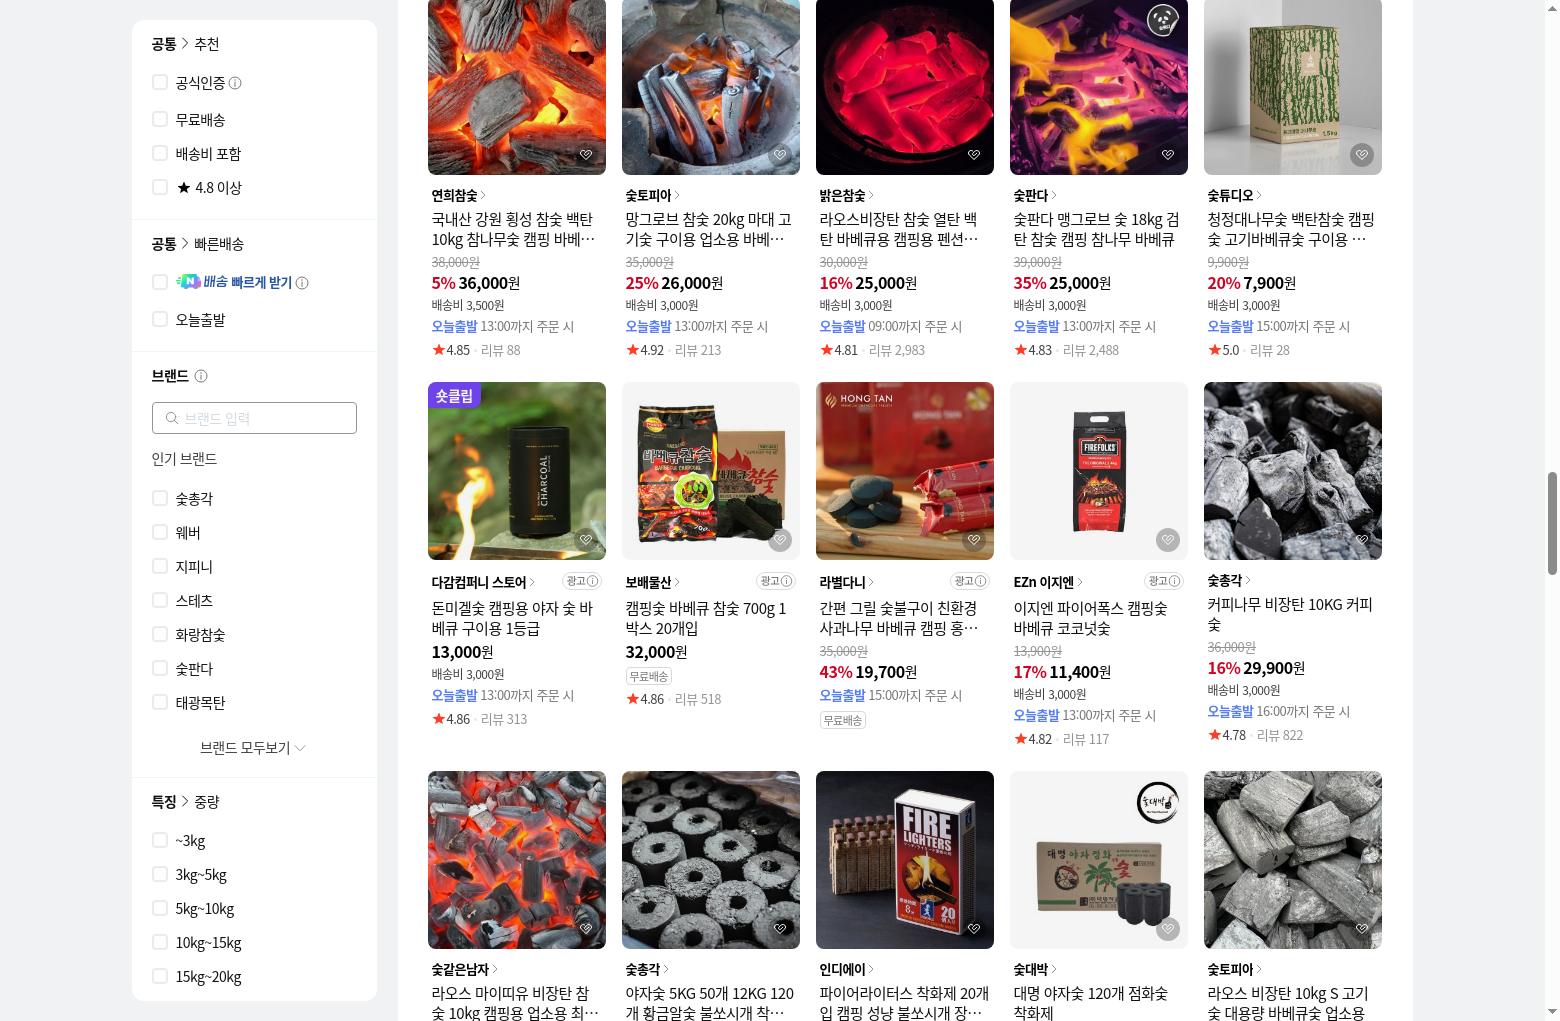

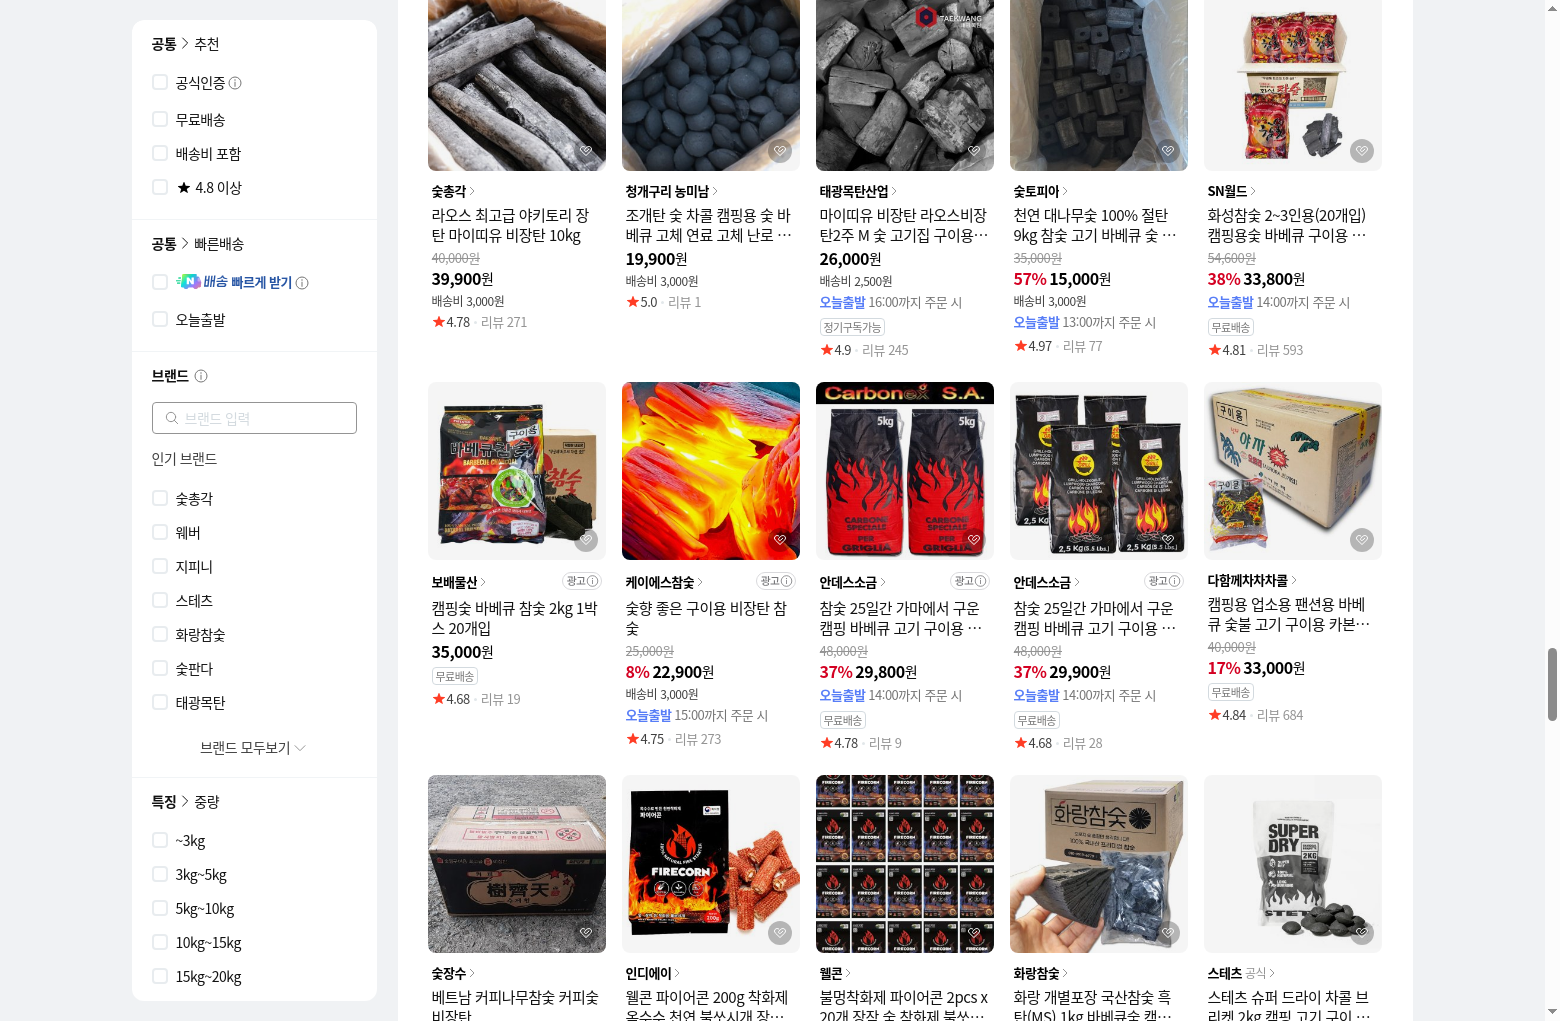

상품 개수: 101
1번째 상품: 돈미겔숯 캠핑용 야자 숯 바베큐 구이용 1등급
2번째 상품: 캠핑숯 바베큐 참숯 700g 1박스 20개입
3번째 상품: 간편 그릴 숯불구이 친환경 사과나무 바베큐 캠핑 홍탄 숯 향
4번째 상품: 이지엔 파이어폭스 캠핑숯 바베큐 코코넛숯
5번째 상품: 커피나무 비장탄 10KG 커피숯
6번째 상품: 라오스 마이띠유 비장탄 참숯 10kg 캠핑용 업소용 최고급 숯 SS
7번째 상품: 야자숯 5KG 50개 12KG 120개 황금알숯 불쏘시개 착화탄 펜션 캠핑 바베큐
8번째 상품: 파이어라이터스 착화제 20개입 캠핑 성냥 불쏘시개 장작 숯 점화제
9번째 상품: 대명 야자숯 120개 점화숯 착화제
10번째 상품: 라오스 비장탄 10kg S 고기숯 대용량 바베큐숯 업소용
11번째 상품: 오류 발생: Message: no such element: Unable to locate element: {"method":"xpath","selector":".//div/a[contains(@class, "basicProductCard")]"}
  (Session info: chrome=135.0.7049.114); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x558cd428175a <unknown>
#1 0x558cd3d344b0 <unknown>
#2 0x558cd3d859b3 <unknown>
#3 0x558cd3d85ba1 <unknown>
#4 0x558cd3d79476 <unknown>
#5 0x558cd3dab5bd <unknown>
#6 0x558cd3d7936a <unknown>
#7 0x558cd3dab75e <unknown>
#8 0x558cd3dd15e0 <unknown>
#9 0x558cd3d

In [42]:
crawler.search_run()

In [33]:
crawler.crwal_df

상품명     가격  \
0   [숯검댕이 대용량]10kg 라오스 마이띠유 비장탄 캠핑 바베큐 백탄 참숯 펜션 구이용SS  24000   
1                       최고급 참숯 백탄 캠핑용 업소용 라오스비장탄 10KG  24900   
2                           커피나무숯 비장탄 백탄 미디움M 10Kg 레몬  29500   
3               친환경 1등급 캠핑용 착화 간편 홍탄 숯 바베큐용 3-4인용 5회분  19700   
4                                   커피나무 비장탄 10KG 커피숯  29900   
..                                                ...    ...   
95         [숯총각 소포장] 두번구운 참숯 백탄 비장탄 맹그로브 맹골 참숯 3단 2KG   5000   
96   숯깨비 바베큐 캠핑 점화탄 조개탄 구이용 펜션용 브리켓 차콜 야자숯 [스피드블랙알숯+]  30900   
97                        숯 번개탄 아래로탄 40개 착화탄 바베큐숯 캠핑숯  32000   
98                  바로타숯 아래로타숯 40개입 착화탄 바베큐 참숯 차콜 번개탄  30900   
99                      야자탄 연기안나는숯 코코넛열탄 동그란숯 성형탄 2kg  11500   

                                                   링크  \
0   https://ader.naver.com/v1/rsttaJd2HLd0HI1-orcN...   
1   https://ader.naver.com/v1/kgV7vl_aTxdUI5ziOZfe...   
2   https://ader.naver.com/v1/qugMDebxbaDy3nrBF-Fw...   
3   https://ader.naver.com/v1/TI0EA8cdAxKnaA1vc_-M...   
4   https://smartstore.naver.com/main/products/450...   
..                                                ...   
95  https://smartstore.naver.com/main/products/265...   
96  https://smartstore.naver.com/main/products/468...   
97  https://smartstore.naver.com/main/products/606...   
98  https://smartstore.naver.com/main/products/247...   
99  https://smartstore.naver.com/main/products/885...   

                                                  이미지  \
0   https://shopping-phinf.pstatic.net/main_877326...   
1   https://shopping-phinf.pstatic.net/main_829966...   
2   https://shopping-phinf.pstatic.net/main_818937...   
3   https://searchad-phinf.pstatic.net/MjAyMzA0MDd...   
4   https://shopping-phinf.pstatic.net/main_820471...   
..                                                ...   
95  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
96  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
97  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
98  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
99  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   

                         이미지_파일  
0   ./data/images/product_1.jpg  
1   ./data/images/product_2.jpg  
2   ./data/images/product_3.jpg  
3   ./data/images/product_4.png  
4   ./data/images/product_5.jpg  
..                          ...  
95                      다운로드 실패  
96                      다운로드 실패  
97                      다운로드 실패  
98                      다운로드 실패  
99                      다운로드 실패  

[100 rows x 5 columns]

In [ ]:
crawler.scroll_page(scroll_count=2)
crawler.parse_products()
crawler.download_images('./data/images')
crawler.save_to_excel('./data/naver_shopping_camping_charcoal.xlsx')
crawler.close()

In [17]:
crawler.products

[]

In [5]:


# 검색어 입력 및 검색
search_word = '캠핑 숯'
search_box = driver.find_element(By.XPATH, '//input[contains(@class, "searchInput_search_text")]')
search_box.clear()
search_box.send_keys(search_word)
search_box.send_keys(Keys.ENTER)

# 페이지 로딩이 완료될 때까지 대기
driver.implicitly_wait(3)

In [6]:
# 스크롤을 사용해서 더 많은 상품 로드
last_height = driver.execute_script("return document.body.scrollHeight")

# 지정한 횟수만큼 스크롤 내림
scroll_count = 1
for i in range(scroll_count):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    driver.implicitly_wait(1)
    # 스크롤 내린 후 높이 측정
    new_height = driver.execute_script("return document.body.scrollHeight")
    # 더 이상 로드되는 내용이 없으면 종료
    if new_height == last_height:
        break
    
    last_height = new_height

# 페이지 소스 가져오기 및 BeautifulSoup 파싱
page_source = driver.page_source
soup = BeautifulSoup(page_source, "html.parser")

In [11]:
# XPath를 사용해서 상품 정보 가져오기
items_path = '//*[@id="composite-card-list"]/div/ul[1]/li'
items = driver.find_elements(By.XPATH, items_path)
items

[<selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159d9977ce14a0761954cd13e", element="f.2F9B7892BB0492710A600FBBA20F0D5F.d.503E474986EED69D713D99D3D809C296.e.65755")>,
 <selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159d9977ce14a0761954cd13e", element="f.2F9B7892BB0492710A600FBBA20F0D5F.d.503E474986EED69D713D99D3D809C296.e.65756")>,
 <selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159d9977ce14a0761954cd13e", element="f.2F9B7892BB0492710A600FBBA20F0D5F.d.503E474986EED69D713D99D3D809C296.e.65757")>,
 <selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159d9977ce14a0761954cd13e", element="f.2F9B7892BB0492710A600FBBA20F0D5F.d.503E474986EED69D713D99D3D809C296.e.65758")>,
 <selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159d9977ce14a0761954cd13e", element="f.2F9B7892BB0492710A600FBBA20F0D5F.d.503E474986EED69D713D99D3D809C296.e.65759")>,
 <selenium.webdriver.remote.webelement.WebElement (session="1b5df6c159

In [17]:
# 상품 정보를 가져오면서 에러가 발생한 경우 예외처리 후 생략
products = []

n = 1
for item in items:
    print(f"{n}번째 상품: ", end="")
    try:
        item_a_tag = item.find_element(By.XPATH, './/div/a[contains(@class, "basicProductCard")]')
        info = item_a_tag.get_attribute('data-shp-contents-dtl')
        info_dict = json.loads(info)
        product_name = next(item['value'] for item in info_dict if item['key'] == 'prod_nm')
        product_price = next(item['value'] for item in info_dict if item['key'] == 'price')
        product_link = item_a_tag.get_attribute('href')
        products.append({
            '상품명': product_name,
            '가격': product_price,
            '링크': product_link
        })
        print(info)
    except NoSuchElementException:
        print("못찾음")
    n += 1

1번째 상품: [{"key":"chnl_prod_no","value":"5969670976"},{"key":"nv_mid","value":"83514170464"},{"key":"click_url","value":"https://smartstore.naver.com/main/products/5969670976"},{"key":"price","value":"27500"},{"key":"cat_id","value":"50002665"},{"key":"loungeonly_yn","value":"n"},{"key":"purchase_yn","value":"n"},{"key":"promotion_yn","value":"n"},{"key":"coupontag_yn","value":"n"},{"key":"nfa_type","value":"오늘출발"},{"key":"prod_nm","value":"[ 캠핑홀릭 숯장군 (벌크상품) ] 국내산 세계유일 7번구운 참숯 1등급 백탄"}]
2번째 상품: [{"key":"chnl_prod_no","value":"11390235607"},{"key":"nv_mid","value":"88934745972"},{"key":"click_url","value":"https://smartstore.naver.com/main/products/11390235607"},{"key":"price","value":"29000"},{"key":"cat_id","value":"50002665"},{"key":"loungeonly_yn","value":"n"},{"key":"purchase_yn","value":"n"},{"key":"promotion_yn","value":"n"},{"key":"coupontag_yn","value":"n"},{"key":"nfa_type","value":"오늘출발"},{"key":"prod_nm","value":"수제천 비장탄 커피나무 커피숯 참숯 캠핑용 업소용 10kg"}]
3번째 상품: [{"key":"chnl_prod_

In [18]:
products

[{'상품명': '[ 캠핑홀릭 숯장군 (벌크상품) ] 국내산 세계유일 7번구운 참숯 1등급 백탄',
  '가격': '27500',
  '링크': 'https://ader.naver.com/v1/KYdCsPQUmi2vD9Cba_IycRhRHMCvDnrxR9DBiRTlXaA6hB0xYm8vyw2C-8iwGS-ZD-Z6s1DH2ujuS8p5nv8tVnIkmeof9aXspeEGT7oBMpzRS7f-k6aJjH-d-k_wIiW8azdc_FtG2ygGaBd3d_9WTQzJ4A8uDjrK0zLVU_ywYKhAMYGaHpkY8kaM7DUz_Y1svrRqVT1KArr8orhI9APHWNhnWMf883eh1Cyg3Qyl3U7DH1EK99fexThDNuGuAwswok5MChvsI9XZQYNMuyNu99UN6BQXyLgh4tZgQjKwa57FSQociMrDYUlXOZNFhBQii6TWYK_sm9ZaUuu0eH54NYsMD3EyQYb_8bKcGEfSUSt3zR5JDzV23vNaSmfpwX2uZlrZ4jvl1BtS8P4awbceR1DT2K1UpxebF-L4M7MpLIC19tf99HDQyQsfEfhMMC_H2Ucb7b3zJsFCgRz9FOAMKG4MMJ0lE4KnmGd2Z6ZZne4=?c=pc.nplusstore.npla&t=0'},
 {'상품명': '수제천 비장탄 커피나무 커피숯 참숯 캠핑용 업소용 10kg',
  '가격': '29000',
  '링크': 'https://ader.naver.com/v1/3tyIt3S-T97Ocp0Y2RJsvsi9gZTQLfxWYMtzRF3YWsKLODZ4HALD3E5rN5hK890LJIxs0V3CEzw_UpVIKTr_wBf5Mu4fO3g4-nFyfDY_6vGKPK3ULZTedJUjxyWqIAgK3xwN9kPEtMZMEOiLF3WB_rYT1D4nd7EcxNYZ4hi2idw0WSdXIpu-mILmGFopMrUoGr4GFIrh6IbQ6DYijmwFKLfW2WHLSepGH0P4RjeKqsgJFYyf1HvBVCk0Zgkb_r6i5FBtgXzWF91CJB6fU0

In [19]:
# 엑셀 파일 경로 지정
path_to_save = './data'
file_name = "naver_shopping_camping_charcoal.xlsx"
file_path = os.path.join(path_to_save, file_name)

# 지정한 경로가 존재하지 않으면 경로 생성
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
    print(f"경로 {path_to_save}가 생성되었습니다.")

# DataFrame으로 변환 후 저장
df = pd.DataFrame(products)
df.to_excel(file_path, index=False)
print(f"엑셀 파일이 {file_path}에 저장되었습니다.")

# WebDriver 종료
driver.quit()

엑셀 파일이 ./data/naver_shopping_camping_charcoal.xlsx에 저장되었습니다.
